In [540]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [541]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
%matplotlib inline

In [542]:
train_raw_df = pd.read_csv("../../data/input/hugging_face/train_raw.csv")
train_raw_df = train_raw_df.sample(frac=1, random_state=4)

train_eda_df = pd.read_csv("../../data/input/hugging_face/train_eda.csv")
train_eda_df = train_eda_df.sample(frac=1, random_state=4)

test_df = pd.read_csv("../../data/input/hugging_face/test.csv")


In [543]:
print(train_raw_df.shape)
print(train_eda_df.shape)

(102, 2)
(1019, 2)


In [544]:
batch_raw = pd.concat([train_raw_df,test_df],
axis=0,
ignore_index=True)
batch_raw.to_csv("../../data/input/hugging_face/data_val/raw_train_test.csv")

batch_eda = pd.concat([train_eda_df,test_df],
axis=0,
ignore_index=True)
batch_eda.to_csv("../../data/input/hugging_face/data_val/eda_train_test.csv")
batch_eda.head()

,op_id,Question
0,46,what areas have an annual amount of snowfall m...
1,39,which houses are larger than square meters and...
2,13,which roll farm marriage proposal are nearest ...
3,39,what houses are for sale localization and with...
4,8,what areas are within meters of the major rout...


In [545]:
print(batch_raw.shape)
print(batch_eda.shape)

(188, 2)
(1105, 2)


In [546]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [547]:
tokenized_raw = batch_raw["Question"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_eda = batch_eda["Question"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [548]:
max_len = 0
for i in tokenized_raw.values:
    if len(i) > max_len:
        max_len = len(i)

padded_raw = np.array([i + [0]*(max_len-len(i)) for i in tokenized_raw.values])
max_len


27

In [549]:
max_len = 0
for i in tokenized_eda.values:
    if len(i) > max_len:
        max_len = len(i)

padded_eda = np.array([i + [0]*(max_len-len(i)) for i in tokenized_eda.values])
max_len

28

In [550]:
np.array(padded_raw).shape


(188, 27)

In [551]:
np.array(padded_eda).shape

(1105, 28)

In [552]:
attention_mask_raw = np.where(padded_raw != 0, 1, 0)
attention_mask_raw.shape

(188, 27)

In [553]:
attention_mask_eda = np.where(padded_eda != 0, 1, 0)
attention_mask_eda.shape

(1105, 28)

In [554]:
input_ids_raw = torch.tensor(padded_raw)  
attention_mask_raw = torch.tensor(attention_mask_raw)
input_ids_eda = torch.tensor(padded_eda)  
attention_mask_eda = torch.tensor(attention_mask_eda)

with torch.no_grad():
    last_hidden_states_raw = model(input_ids_raw, attention_mask=attention_mask_raw)
    last_hidden_states_eda = model(input_ids_eda, attention_mask=attention_mask_eda)

In [555]:
features_raw = last_hidden_states_raw[0][:,0,:].numpy()
features_eda = last_hidden_states_eda[0][:,0,:].numpy()

In [556]:
labels_raw = batch_raw["op_id"]
labels_eda = batch_eda["op_id"]

In [557]:
labels_raw.shape

(188,)

In [558]:
labels_eda.shape

(1105,)

In [559]:
train_raw_shape = train_raw_df.shape
train_raw_features = features_raw[:train_raw_shape[0]]
test_raw_features = features_raw[train_raw_shape[0]:]
train_raw_labels = labels_raw[:train_raw_shape[0]]
test_raw_labels =labels_raw[train_raw_shape[0]:] 

In [ ]:
print(train_raw_features)
print(test_raw_features)
print(train_raw_labels)
print(test_raw_labels)

In [560]:
train_eda_shape = train_eda_df.shape
train_eda_features = features_eda[:train_eda_shape[0]]
test_eda_features = features_eda[train_eda_shape[0]:]
train_eda_labels = labels_eda[:train_eda_shape[0]]
test_eda_labels =labels_eda[train_eda_shape[0]:] 

In [ ]:
print(train_eda_features)
print(test_eda_features)
print(train_eda_labels)
print(test_eda_labels)

In [561]:
train_raw_features.shape

(102, 768)

In [562]:
train_eda_features.shape

(1019, 768)

In [563]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

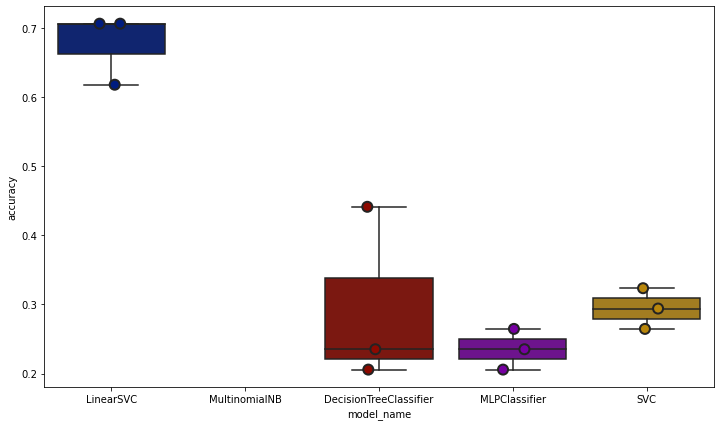

In [564]:
models = [
    LinearSVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    MLPClassifier( solver="sgd", random_state=2343),
    SVC(kernel='poly',
        random_state=494,
        degree=7
    )
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,train_raw_features, train_raw_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/huggingface/test.png",bbox_inches='tight')
plt.show()

In [565]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.294118
LinearSVC                 0.676471
MLPClassifier             0.235294
MultinomialNB                  NaN
SVC                       0.294118
Name: accuracy, dtype: float64

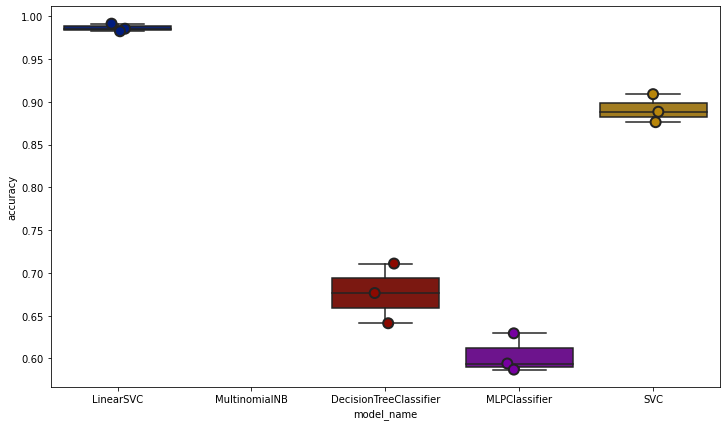

In [566]:
models = [
    LinearSVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    MLPClassifier( solver="sgd", random_state=2343),
    SVC(kernel='poly',
        random_state=494,
        degree=7
    )
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,train_eda_features, train_eda_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [567]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.676187
LinearSVC                 0.986257
MLPClassifier             0.603517
MultinomialNB                  NaN
SVC                       0.891055
Name: accuracy, dtype: float64

In [568]:
# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

[13 13 14  8  8  8  8  6  6  6  6  6  8  8  8  8  8 53 53 53  8  8  8 19
 19 19 19 19 46 46 46 46 44 39 39 39 14 14 19 15 15  5 28  5  5  5 11 11
 33 33  0 28 32 16 16 28 28 28 28 27 50  0 28 11 33  0 50 21 21 18  0 18
 18 18 18 18 53  0  0 50 42 19 18 13 13 13]


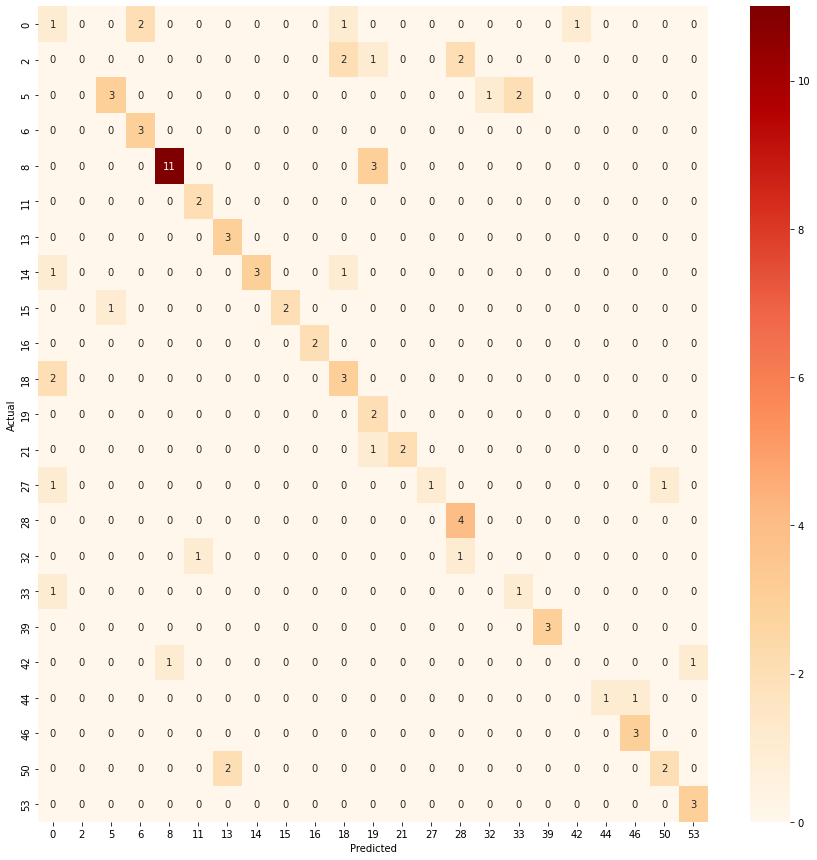

In [569]:
model = LinearSVC()

model.fit(train_raw_features, train_raw_labels)
y_pred = model.predict(test_raw_features)
print(y_pred)


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_raw_labels, y_pred)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(test_raw_labels.values))), 
            yticklabels=sorted(list(set(test_raw_labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [570]:
from sklearn import metrics

unique_keys = sorted(list(set(test_raw_labels.values)))
print('accuracy %s' %metrics.accuracy_score(y_pred,test_raw_labels))

accuracy 0.6395348837209303


In [571]:
model.score(test_raw_features,test_raw_labels)

0.6395348837209303

[13 13 14  8  8  8  8  6  6  6  6  6  8  8  8  8  8 53 53 53  8 19  8 19
 19 19 19 19 46 46 46 46 44 39 39 39 14 14 19 15 15  5 28  5  5  5 11 11
 33 32  0 28 32 16  2 28 28  2 28  2 27  0  5 11 33  0 50 21 21 18 18 18
 18 18 18  0 53  0  0 50  0 19  0 13 13 13]


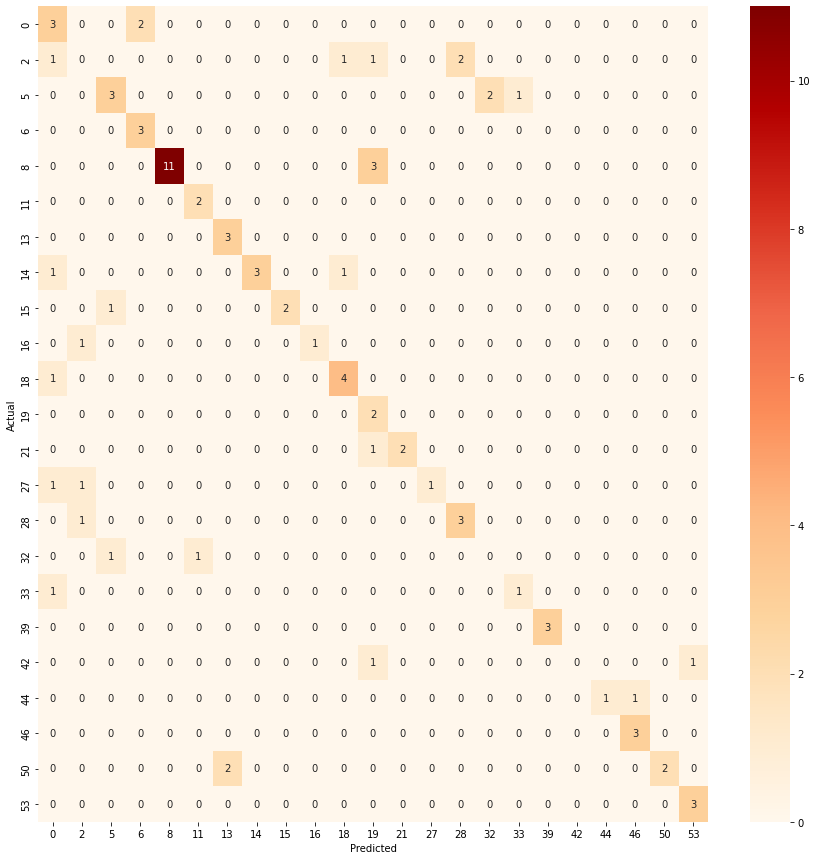

In [572]:
model = LinearSVC()

model.fit(train_eda_features, train_eda_labels)
y_pred = model.predict(test_eda_features)
print(y_pred)




from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_eda_labels, y_pred)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(test_raw_labels.values))), 
            yticklabels=sorted(list(set(test_raw_labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [573]:
print('accuracy %s' %metrics.accuracy_score(y_pred,test_eda_labels))

accuracy 0.6511627906976745
